In [1]:
import numpy as np
import matplotlib
import pathlib
import mne
import matplotlib.pyplot as plt

In [2]:
# use this can show graph in new page!
# useful!
# matplotlib.use('Qt5Agg')

In [3]:
def read_fif(name):
  """
   use mne read fif data
   return back raw data
  """
  fname = 'OpenMIIR-RawEEG_v1/'+ name + '-raw.fif'
  raw = mne.io.read_raw_fif(fname, preload=True)
  return raw

In [4]:
# we write our own read fif function by using mne
raw = read_fif('P01')
raw

Opening raw data file OpenMIIR-RawEEG_v1/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


<Raw | P01-raw.fif, 69 x 2478166 (4840.2 s), ~1.27 GB, data loaded>

## Step 1: data pre-processing

### Learn our datasets

#### We will use P01 subject to show how we do the data pre-processing part

Using matplotlib as 2D backend.


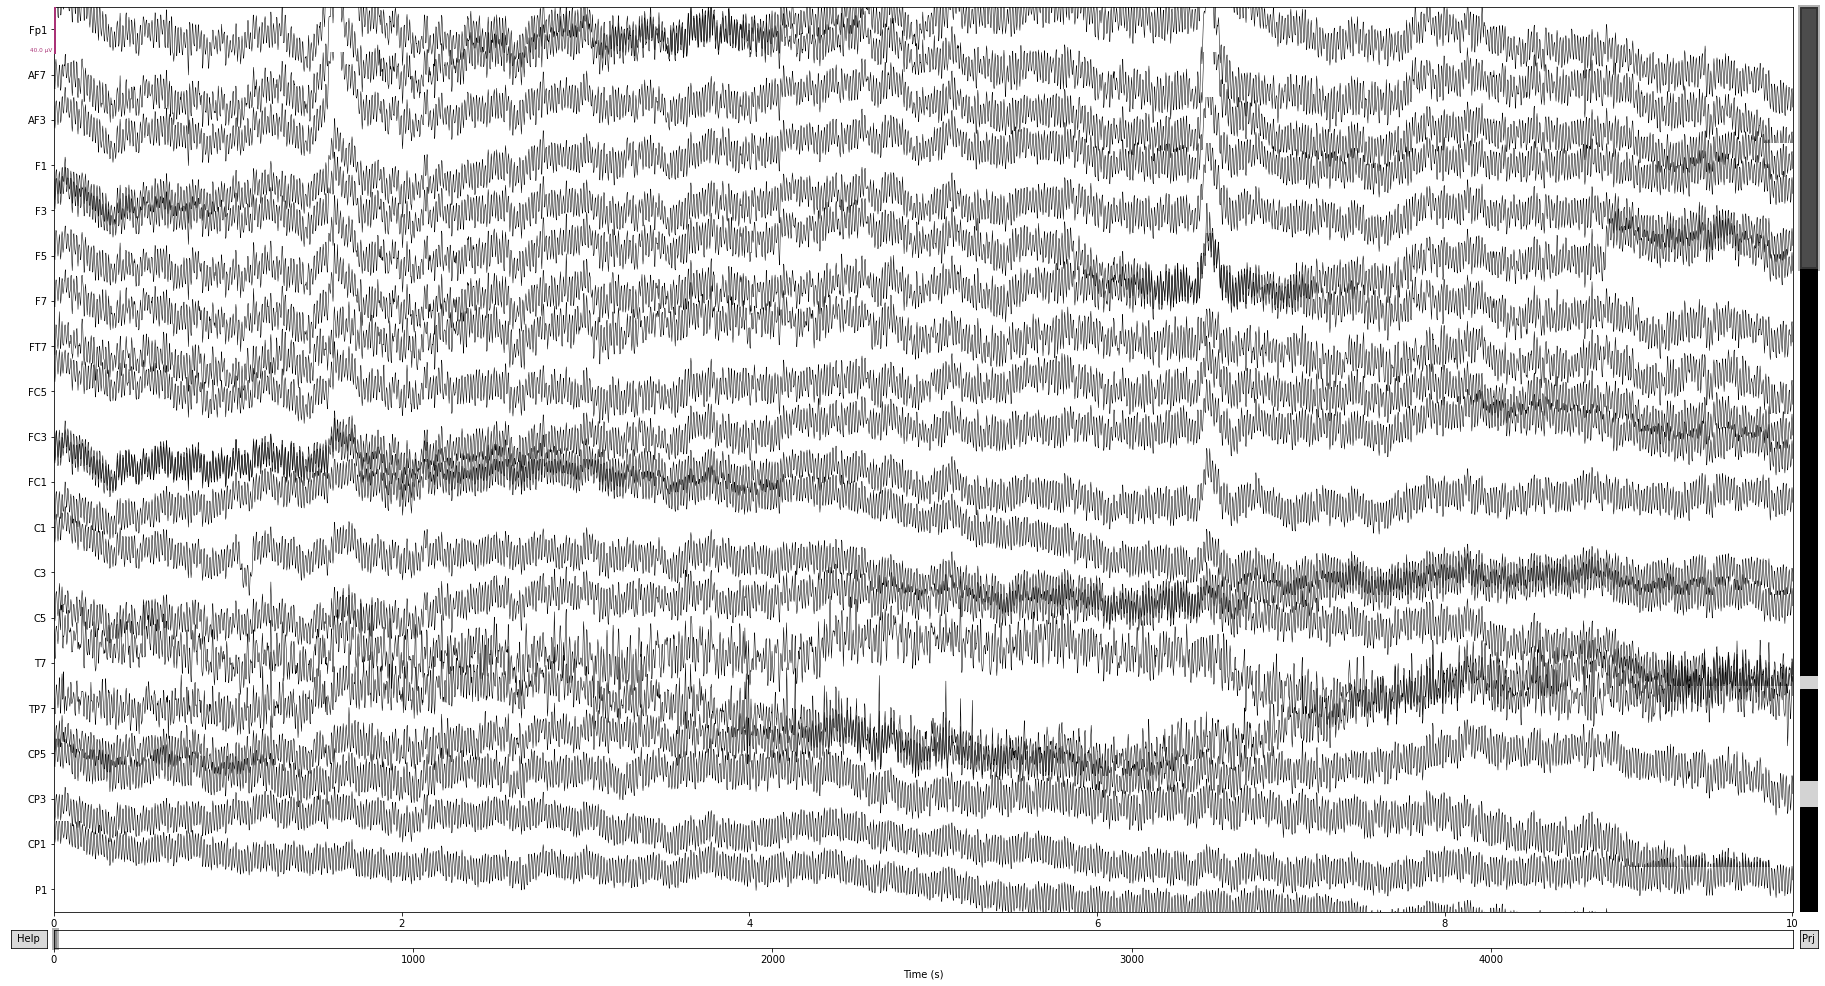

In [5]:
# check raw data plot 
fig = raw.plot()
plt.show()


In [6]:
# want to know how many events do we have
events = mne.find_events(raw) 

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]


C:\Users\87678\AppData\Local\Temp\ipykernel_2272\2359974284.py:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events)


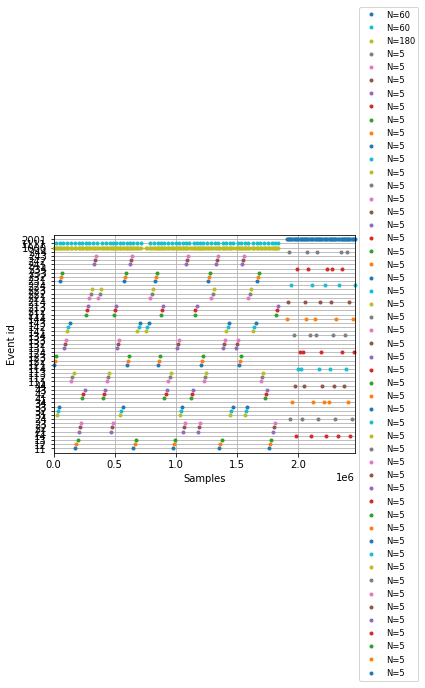

In [7]:
# show events graph
# we want to know each events happen times
fig = mne.viz.plot_events(events)

### Visualize the sensor locations

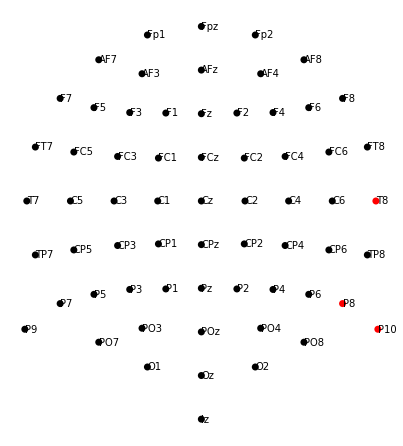

In [8]:
# we want to know which channel being used
# it can show which channels are bad channels too
fig = raw.plot_sensors(show_names=True)

### Filter

In [9]:
# The data was then filtered with a bandpass keeping a frequency range between 0.5 and 30 Hz. 
# This also removed any slow signal drift in the EEG
filt_raw = raw.copy().filter(l_freq=0.5, h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 sec)



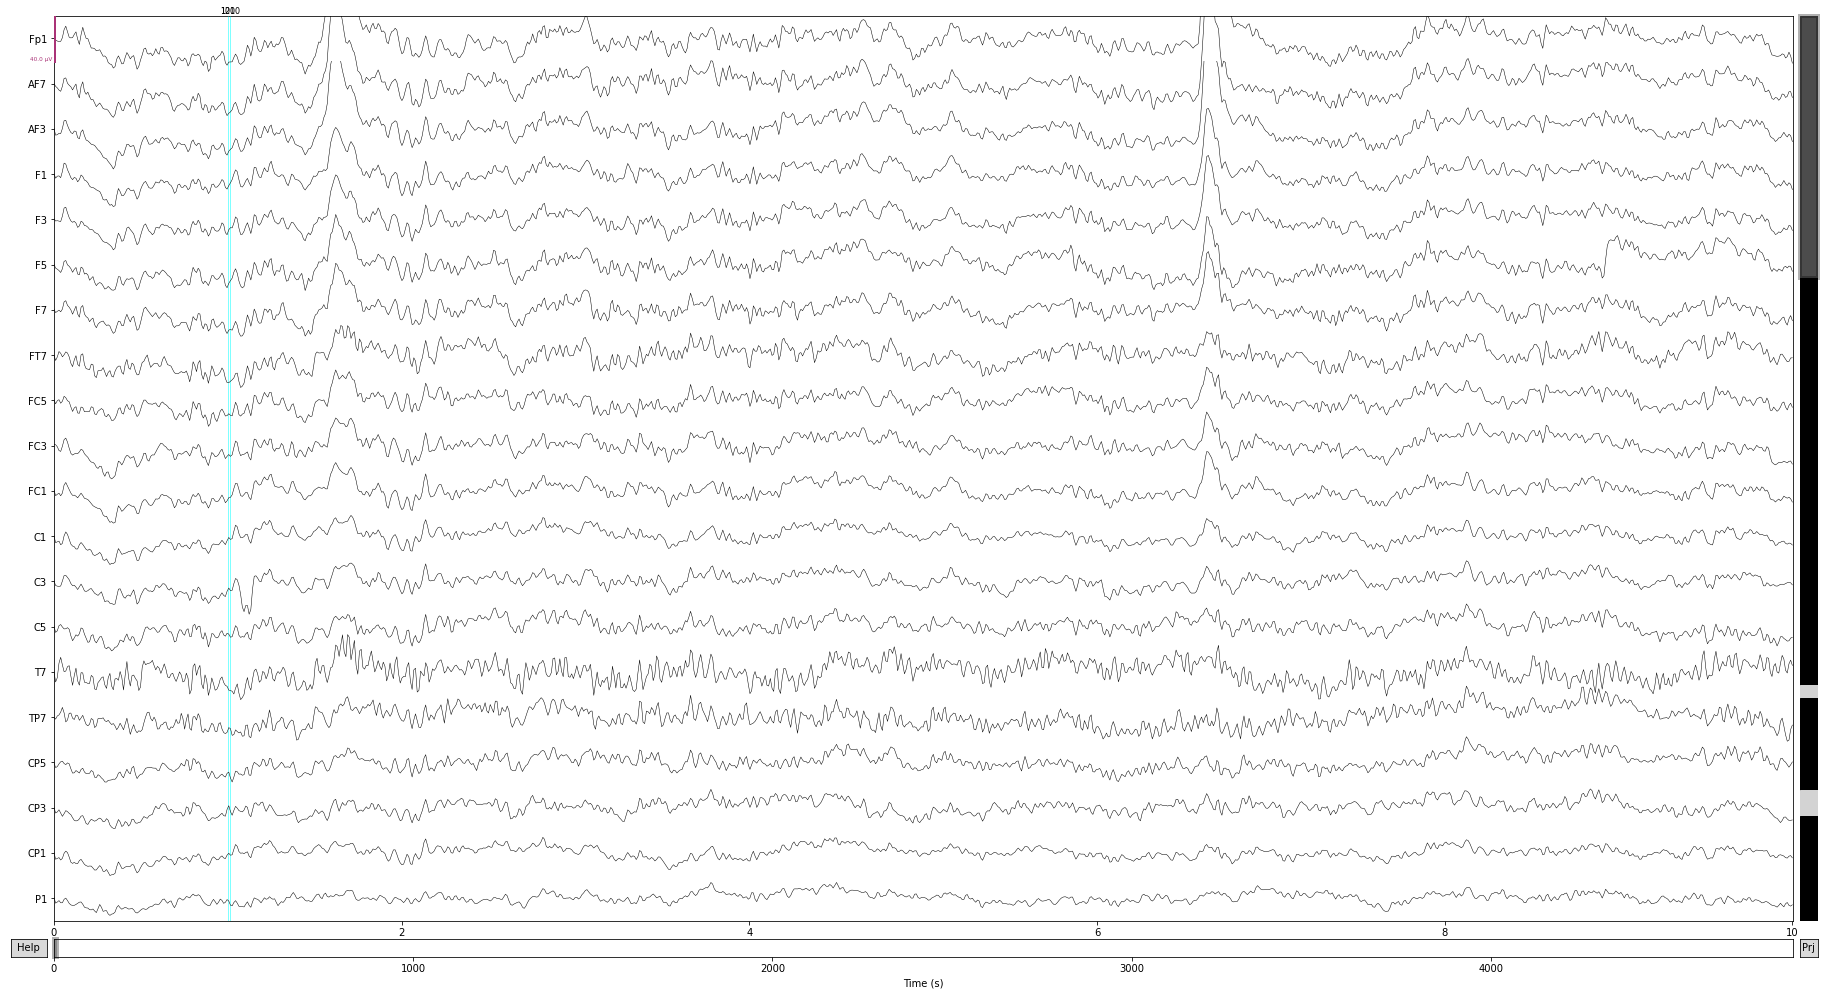

In [10]:
# plot after filter
fig = filt_raw.plot(events=events)

### Repairing artifacts with ICA

Refe:
Repairing artifacts with ICA:
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

In [11]:
ica = mne.preprocessing.ICA(n_components=20, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 47.7s.


<ICA | raw data decomposition, method: fastica (fit in 30 iterations on 2478166 samples), 20 ICA components explaining 95.9 % of variance (61 PCA components available), channel types: eeg, no sources marked for exclusion>

Creating RawArray with float64 data, n_channels=24, n_times=2478166
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.


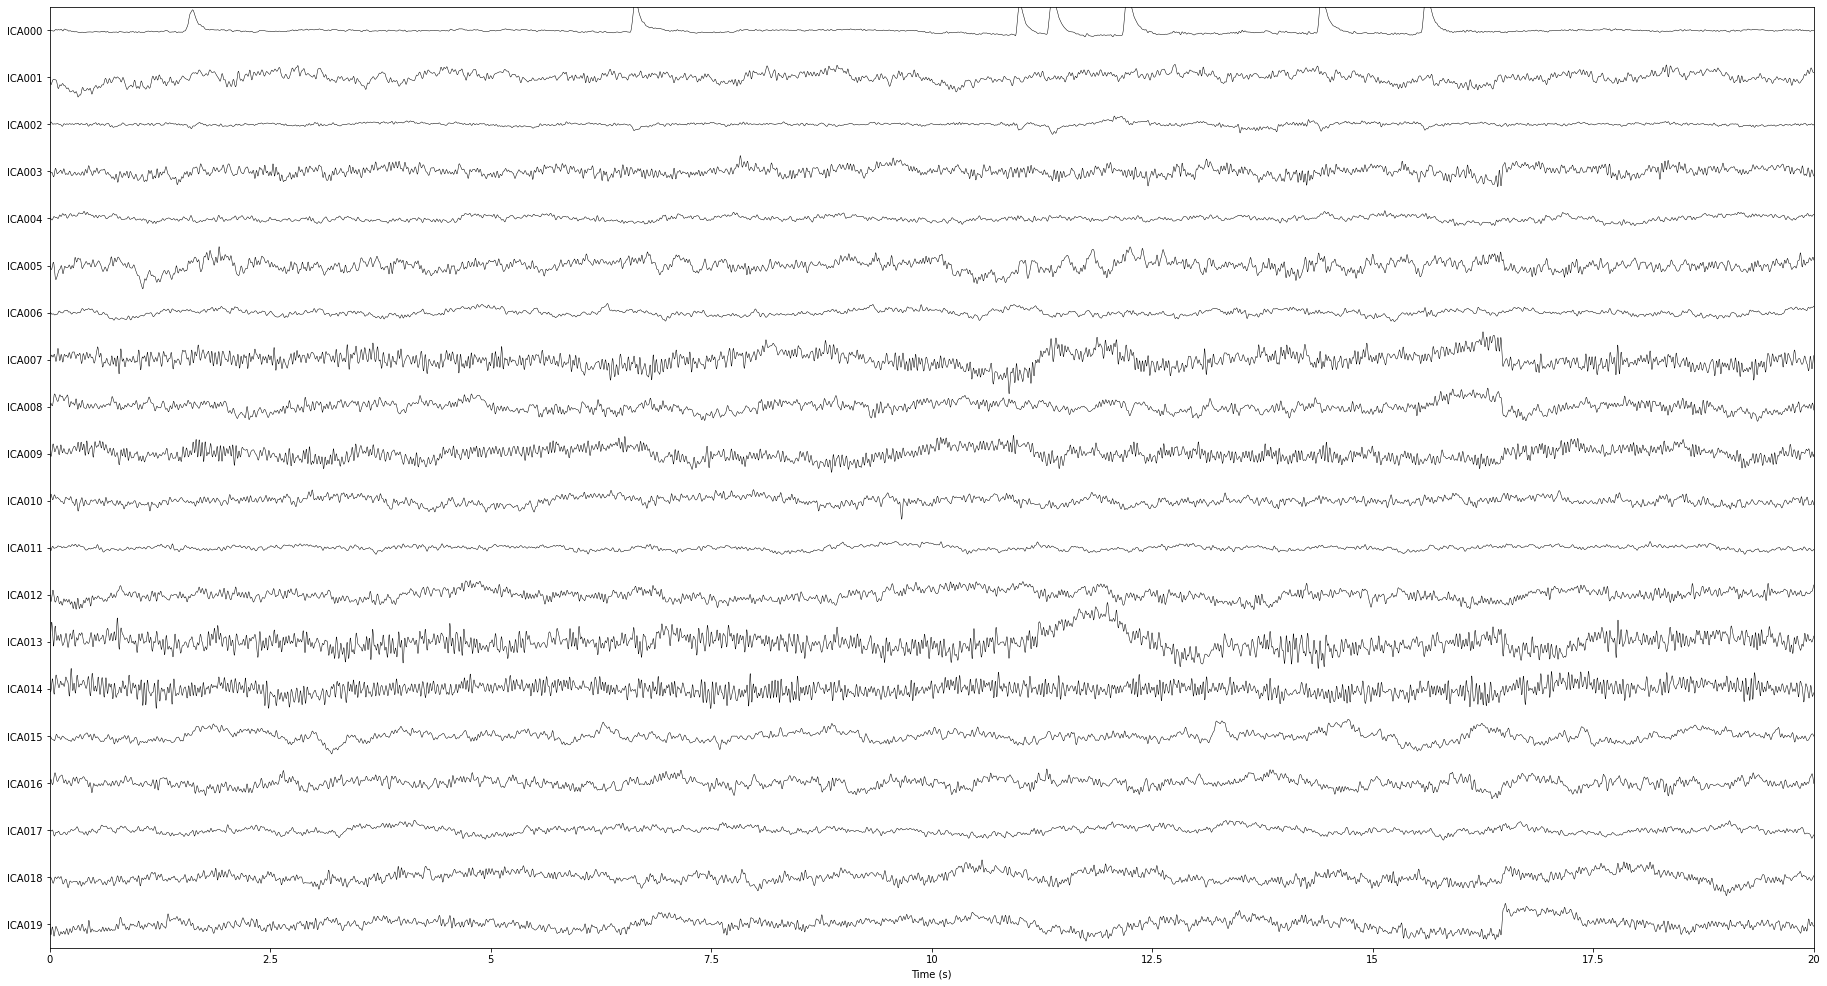

In [12]:
# Now we can examine the ICs to see what they captured. 
# plot_sources will show the time series of the ICs.
filt_raw.load_data()
# This can help us determine which ICs we need to drop
fig = ica.plot_sources(filt_raw, show_scrollbars=False)

EEG Independent Component Labeling:
https://labeling.ucsd.edu/tutorial/labels

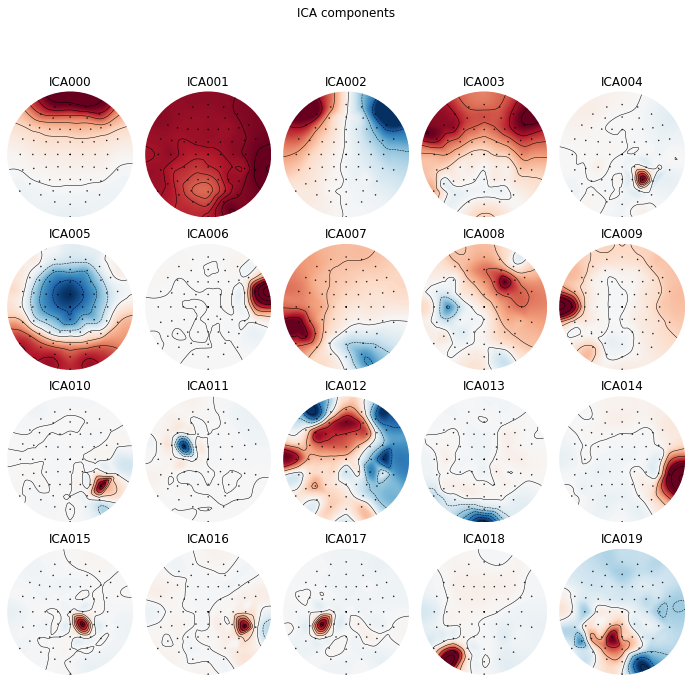

In [13]:
# We can also visualize the scalp field distribution of each component using plot_components.
fig = ica.plot_components()

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


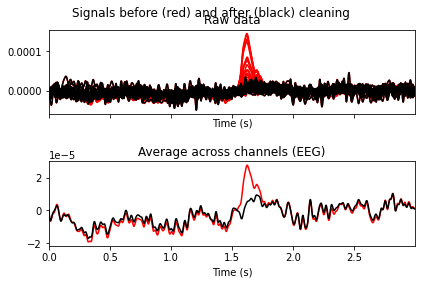

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


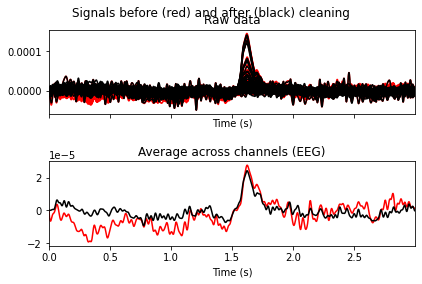

In [14]:
# we can plot an overlay of the original signal against 
# the reconstructed signal with the artifactual ICs excluded

# eye blinks
fig1 = ica.plot_overlay(filt_raw, exclude=[0], picks='eeg')
# heartbeats
fig2 = ica.plot_overlay(filt_raw, exclude=[1], picks='eeg')

In [15]:
ica.exclude = [0, 1]  # indices chosen based on various plots above

Using EOG channels: EXG1, EXG2, EXG3, EXG4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff f

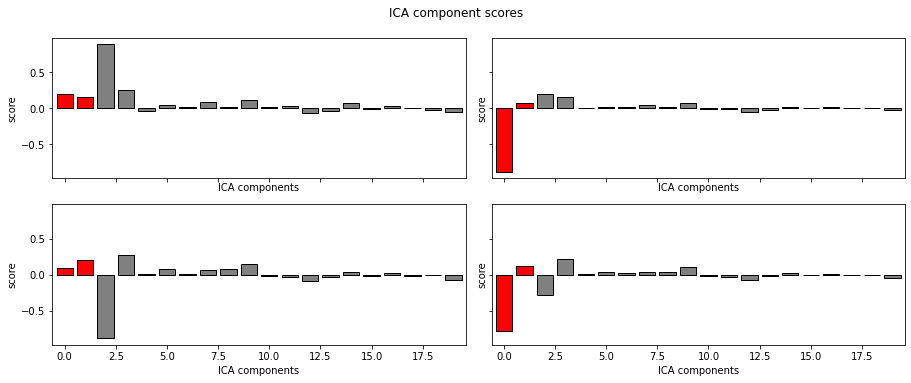

In [16]:
# barplot of ICA component "EOG match" scores
# We can use EOG channel to select ICA components
eog_indices, eog_scores = ica.find_bads_eog(raw)
fig = ica.plot_scores(eog_scores)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


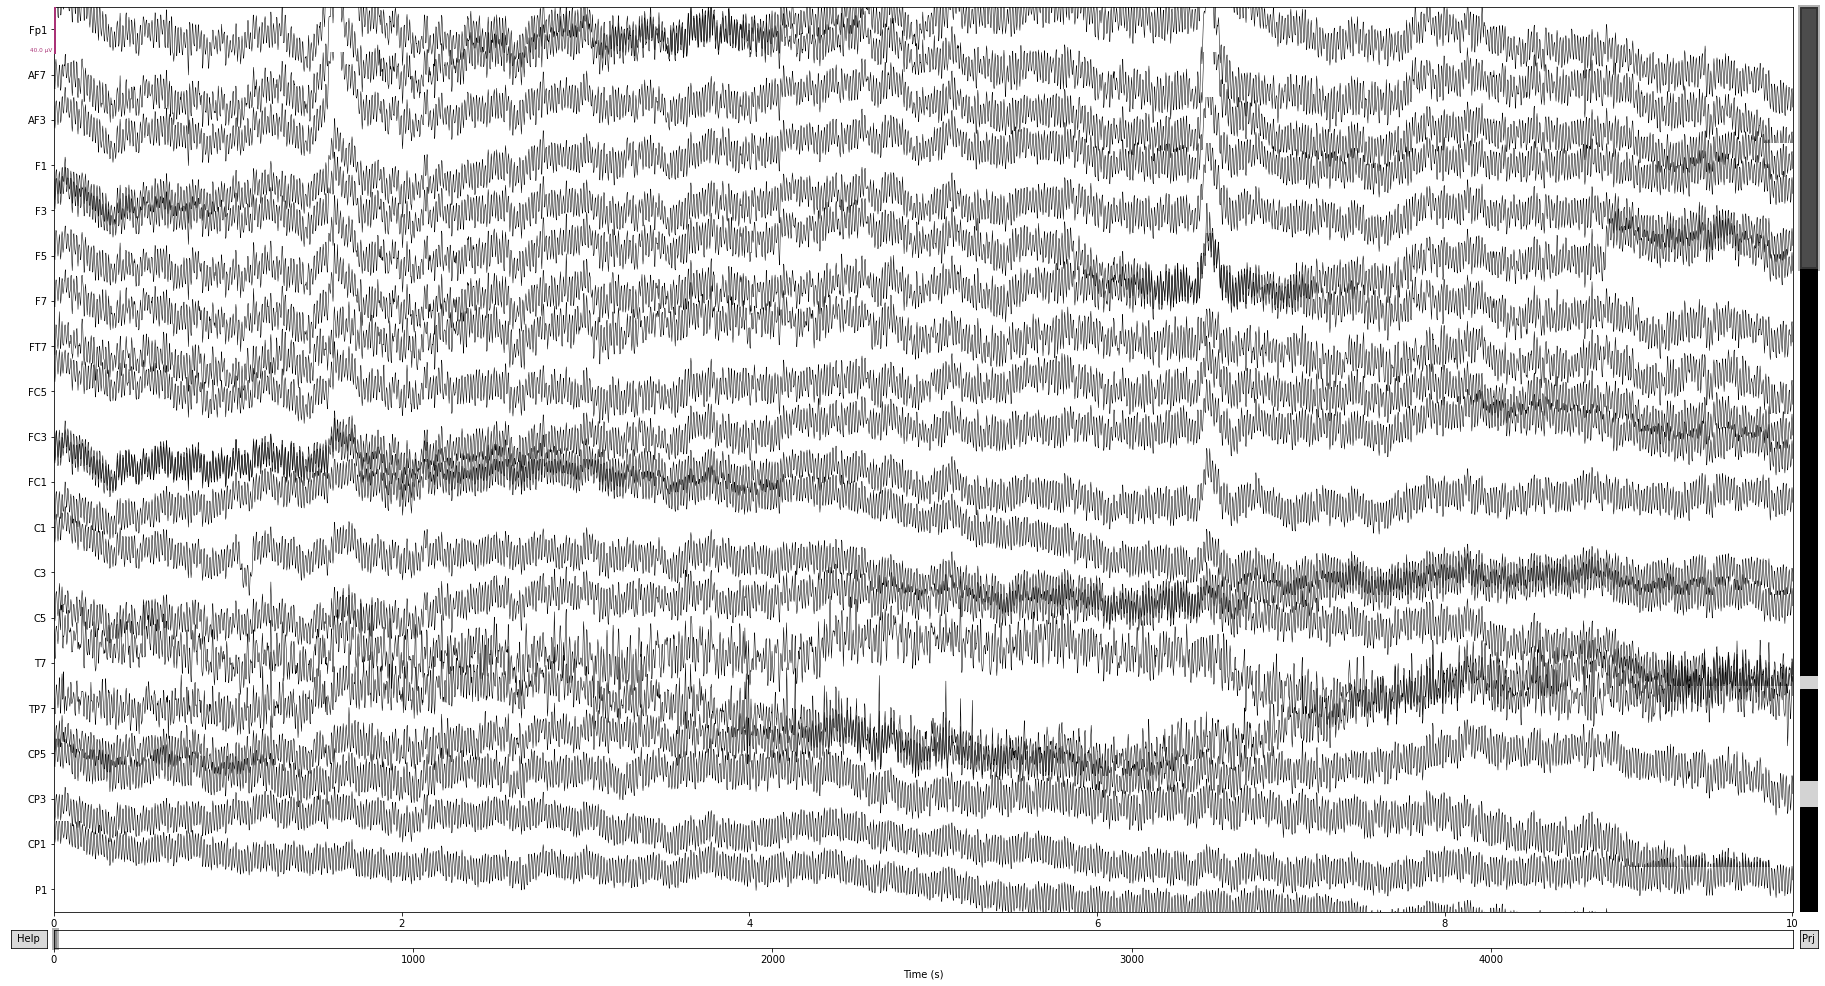

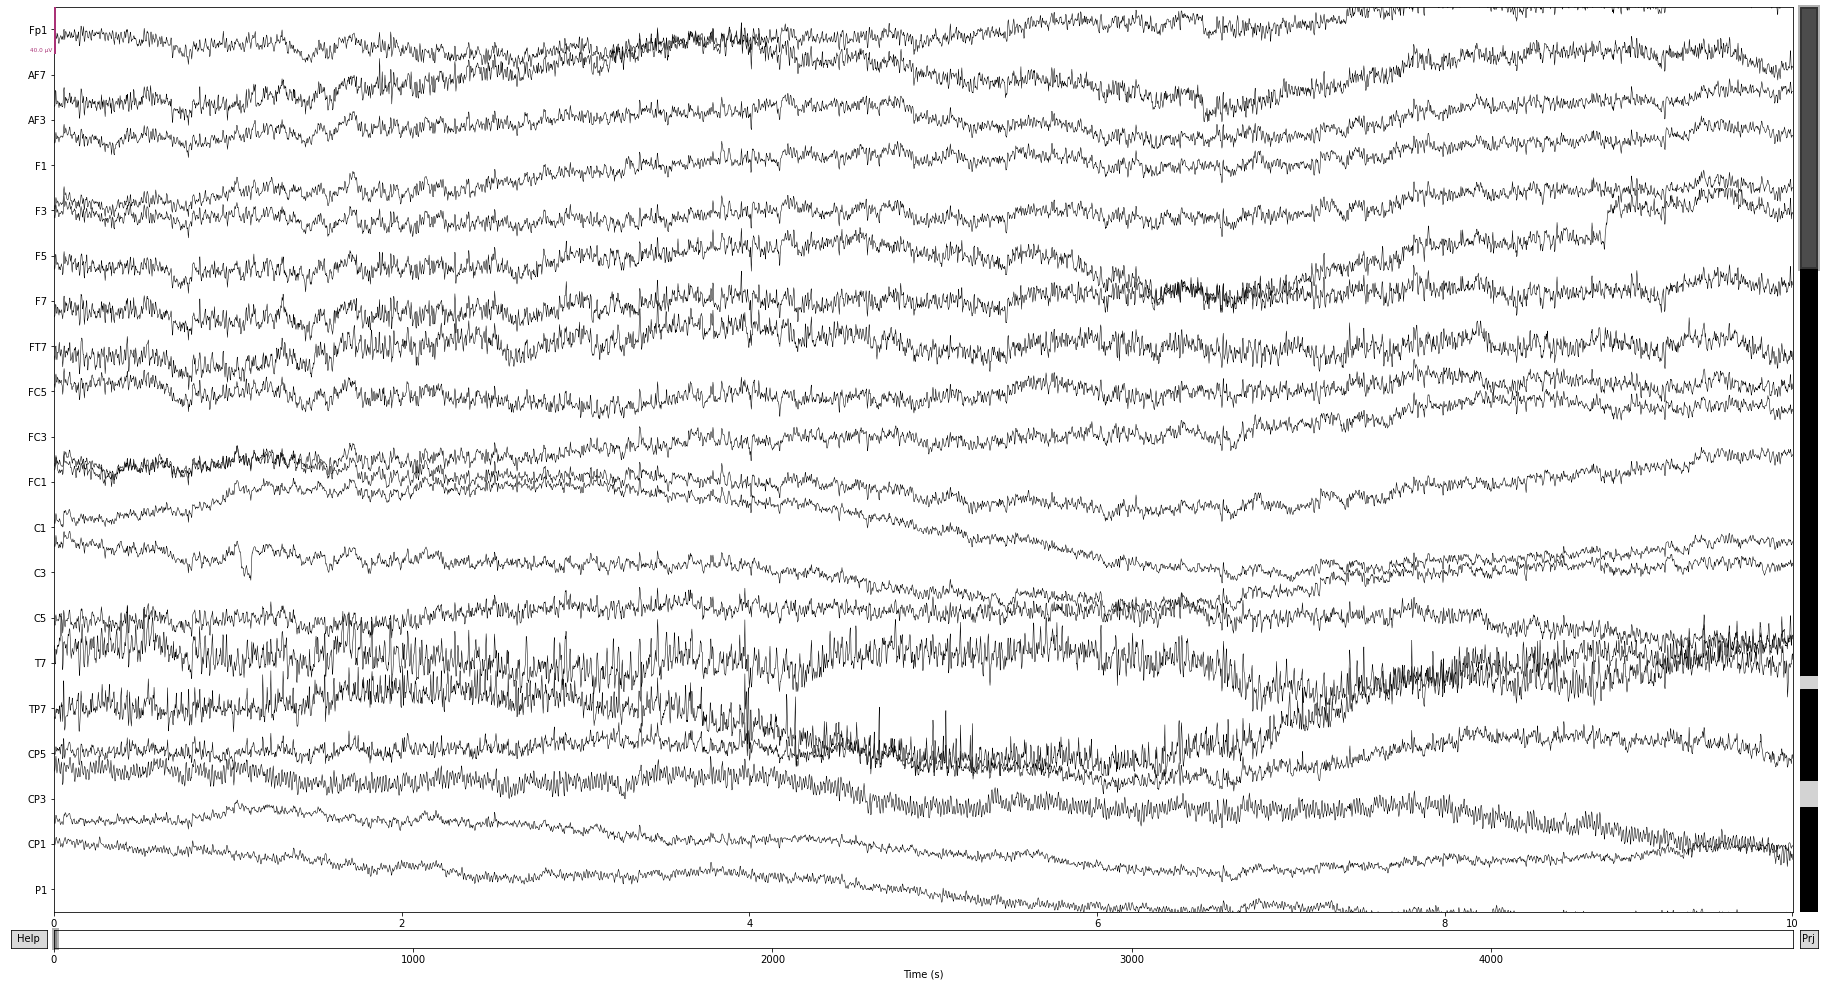

In [17]:
# we can compare raw_data before ica deal with artifacts and after 

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

raw.plot()
reconst_raw.plot()
del reconst_raw

### Evoked responses: epoching and averaging

In [18]:
# Now we can extract epochs from the continuous data
# get_epochs is our own method 
epochs = mne.Epochs(filt_raw, events, preload=True)
epochs = ica.apply(epochs, exclude=ica.exclude)
epochs

Not setting metadata
Not setting metadata
540 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
1 projection items activated
Loading data for 540 events and 359 original time points ...
0 bad epochs dropped
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


C:\Users\87678\AppData\Local\Temp\ipykernel_2272\1915041370.py:4: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs = ica.apply(epochs, exclude=ica.exclude)


<Epochs |  540 events (all good), -0.199219 - 0.5 sec, baseline -0.199219 – 0 sec, ~102.1 MB, data loaded,
 '1000': 180
 '11': 5
 '111': 5
 '1111': 60
 '112': 5
 '113': 5
 '114': 5
 '12': 5
 '121': 5
 '122': 5
 '123': 5
 '124': 5
 '13': 5
 '131': 5
 '132': 5
 '133': 5
 '134': 5
 '14': 5
 '141': 5
 '142': 5
 '143': 5
 '144': 5
 '2001': 60
 '21': 5
 '211': 5
 '212': 5
 '213': 5
 '214': 5
 '22': 5
 '221': 5
 '222': 5
 '223': 5
 '224': 5
 '23': 5
 '231': 5
 '232': 5
 '233': 5
 '234': 5
 '24': 5
 '241': 5
 '242': 5
 '243': 5
 '244': 5
 '31': 5
 '32': 5
 '33': 5
 '34': 5
 '41': 5
 '42': 5
 '43': 5
 '44': 5>

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


C:\Users\87678\AppData\Local\Temp\ipykernel_2272\1184698491.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = epochs.plot(events=events)


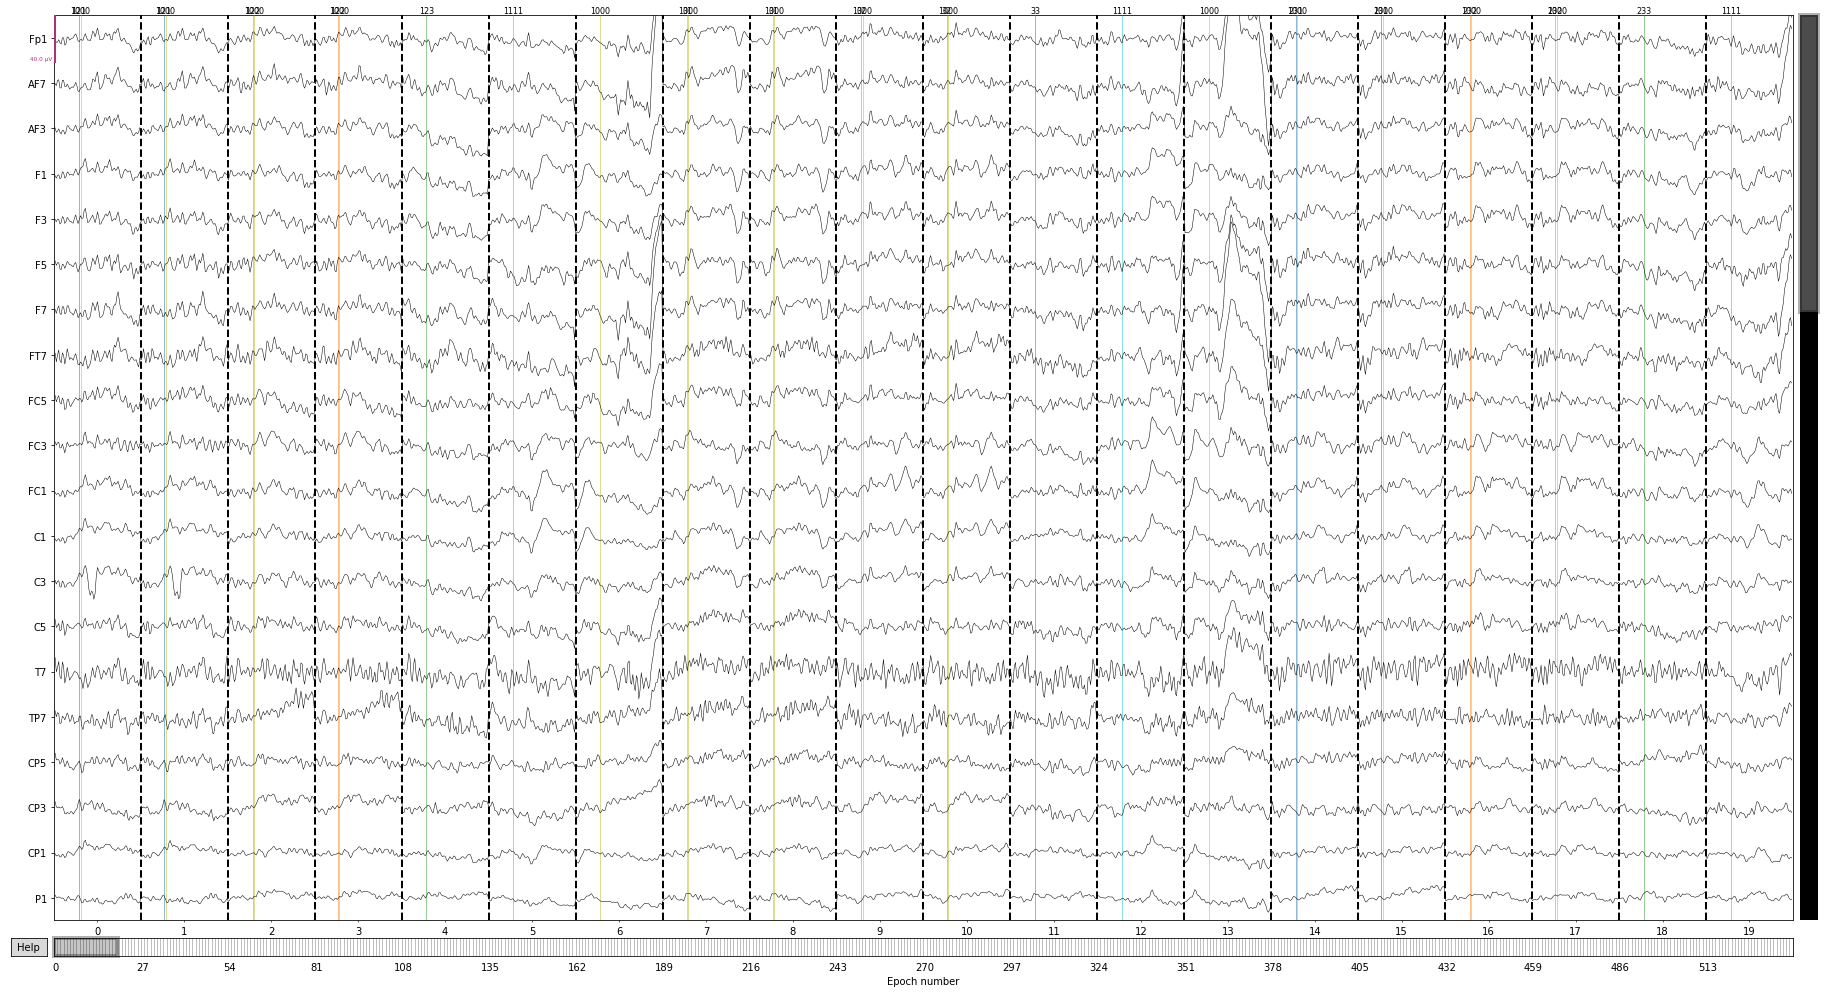

In [19]:
# plot the epochs graph 
fig = epochs.plot(events=events)

### Figure out which channel is good to use

In [20]:
# let’s look at our evoked responses for some conditions we care about. 
# pick any events we want ex. events 11
events_11 = epochs['11'].average()
# l_vis = epochs[2].average()

Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>


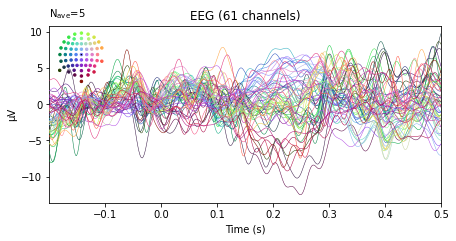

In [21]:
# we can check each channel graph for this events
# This can help us pick the best channel we want to do training
fig = events_11.plot(spatial_colors=True)

No projector specified for this dataset. Please consider the method self.add_proj.


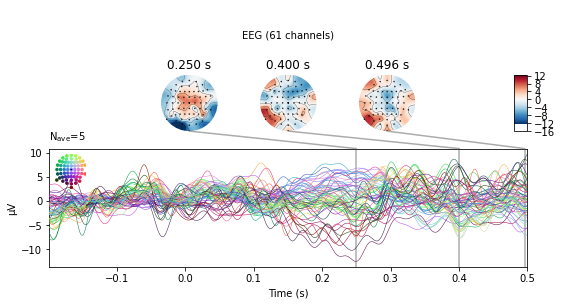

In [22]:
# Scalp topographies can also be obtained non-interactively with the plot_topomap method
fig = events_11.plot_joint()

We think one channel is not enough, we may need combine all 61 channels. However, each subject may have different bad channels. We want to pick same channels for each subject.
Therefore, we use MNE to determine all subjects bad channels. Here are results:

| Subjects      | Bad Channels |
| ----------- | ----------- |
| P01      | P8, P10, T8      |
| P04   | T8        |
| P06      | Iz, FT4       |
| P07   | None        |
| P09      | None       |
| P11   | T7, T8        |
| P12      | C3, PO3       |
| P13   | Iz        |
| P14   | T7, F7        |

According above tale, we drop this bad channel list: [C3, F7, FT4, Iz, P8, P10, PO3, T7, T8]

In [23]:
# We can drop this bad channel list, and create a good channel list
bad_channel_list = ['C3', 'F7', 'FT4', 'Iz', 'P8', 'P10', 'PO3', 'T7', 'T8', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'STI 014']
all_channel_list = raw.ch_names
good_channel = [i for i in all_channel_list if i not in bad_channel_list]
print('Channels length: '+ str(len(good_channel)))
good_channel

Channels length: 56


['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C5',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'O1',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'PO8',
 'PO4',
 'O2']

Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


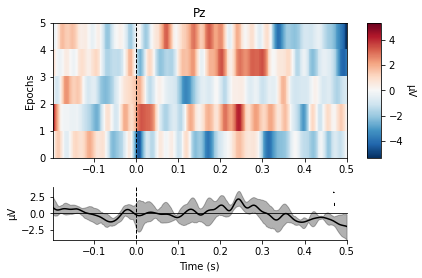

[<Figure size 432x288 with 4 Axes>]

In [24]:
# after we pick the channel
# check more specific info for this channel during events <11>
# for example, we pick channel Pz
epochs['11'].plot_image(picks=['Pz'])

## Step2: Get the Data We Need

#### We will use P01 subject to show how we get data for each subject

### First, we write some helper function to help us deal with some data

In [25]:
def drop_useless_events(events):
  """
    1. drop non-music events,ex:1000,1111,2001
    2. drop condition 4
  """
  # drop >= 1000
  events = [i for i in events if not int(i) >= 1000]

  result = [ele for ele in events if not ele.endswith("4")]
  return result

In [26]:
def avg_events(epochs, channels, events):
  """
   Each events will repeat 5 times for each subject, 
   so we first average all 5 repeat events data to 1.
   Next, we average all 56 good channels to 1.
   return result back
  """
  epochs = epochs.copy()
  result = {}
  for event in events:
    epochs_avg = epochs[event].average()
    epochs_avg_channels = epochs_avg.copy().pick_channels(channels)
    data = epochs_avg_channels.get_data()
    # average all 56 channels
    result[event] = data.mean(axis=0)
  return result

In [27]:
# which events do we need to predict?
event_id = drop_useless_events(epochs.event_id)

### Save result to events_dic_avg

In [28]:
%%capture 
# hide output
events_dic_avg = avg_events(epochs, good_channel, event_id)

Each events has 359 points. Data Type Dict, Key: events ID, Value: List of 359 points

In [29]:
# for example events 11 with conditons 2
# print first ten
print(events_dic_avg['112'][:10])

[-2.08896409e-07 -2.70247853e-07 -3.34361656e-07 -3.98554936e-07
 -4.57174048e-07 -5.02487049e-07 -5.25816833e-07 -5.19129708e-07
 -4.76708698e-07 -3.96227859e-07]


### Minimize the number of points
Minimize the number of points in each events from 359 to 60

In [30]:
def minimize_event(events_dic):
  result = {}
  for key in events_dic:
    point_list = []
    points = events_dic[key]
    splits = np.array_split(points, 60)
    for g in splits:
      ave = sum(g) / len(g)
      point_list.append(ave)
    result[key] = point_list
  return result

In [31]:
events_dic_avg_min = minimize_event(events_dic_avg)

Each events has 60 points. Data Type Dict, Key: events ID, Value: List of 60 points

In [32]:
print(events_dic_avg_min['112'])
print(len(events_dic_avg_min['112']))

[-3.6195365838401103e-07, -3.8822701947248796e-07, 4.186965261311063e-07, 6.514715005135365e-07, 5.60091012373935e-07, 1.242549564070255e-06, 8.381584574764398e-07, -2.1296865078708282e-07, 6.217491005040589e-08, -2.6083648342131233e-07, -1.0610987056267474e-06, -5.68470706472091e-07, -7.568232441905335e-07, -8.259980968369172e-07, 4.6353392242684135e-07, 3.5375539631145247e-07, -1.9409354690191937e-07, 3.402026351156233e-07, 3.4357161476313484e-07, 3.061723303513547e-07, 7.97172936738131e-07, 1.5755535241076028e-06, 2.165612389545359e-06, 1.6301433409249415e-06, 1.3780507153315455e-06, 1.6201203619590922e-06, 1.1477254569596636e-06, 8.677829682270314e-07, 6.65341441631214e-07, 5.37651561224311e-07, 1.1980485345396437e-06, 1.7195026398890188e-06, 1.8007151128239642e-06, 2.082661506971477e-06, 2.8556567413319206e-06, 3.3999625529413727e-06, 3.395846335980678e-06, 3.5375443879374793e-06, 3.6034810017232458e-06, 3.7602535283289285e-06, 3.819877973315204e-06, 3.6787416287545398e-06, 4.0195

## Step 3: Get data for multiple subjects

Having only one subject's data is clearly not enough for training data. After we get the data of the first subject, we need to repeat the previous steps to get the data of several more subjects to help us complete the subsequent training data. 

According to the article "Toward Studying Music Cognition with Information Retrieval Techniques: Lessons Learned from the OpenMIIR Initiative", it meations that " one participant was excluded for the experiments described in this paper because of a considerable number of trials with movement artifacts due to coughing."\
We check each subject data plot and then figure out subject P05 should be dropped from our experiments

Opening raw data file OpenMIIR-RawEEG_v1/P05-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2521101 =      0.000 ...  4924.025 secs
Ready.
Reading 0 ... 2521101  =      0.000 ...  4924.025 secs...


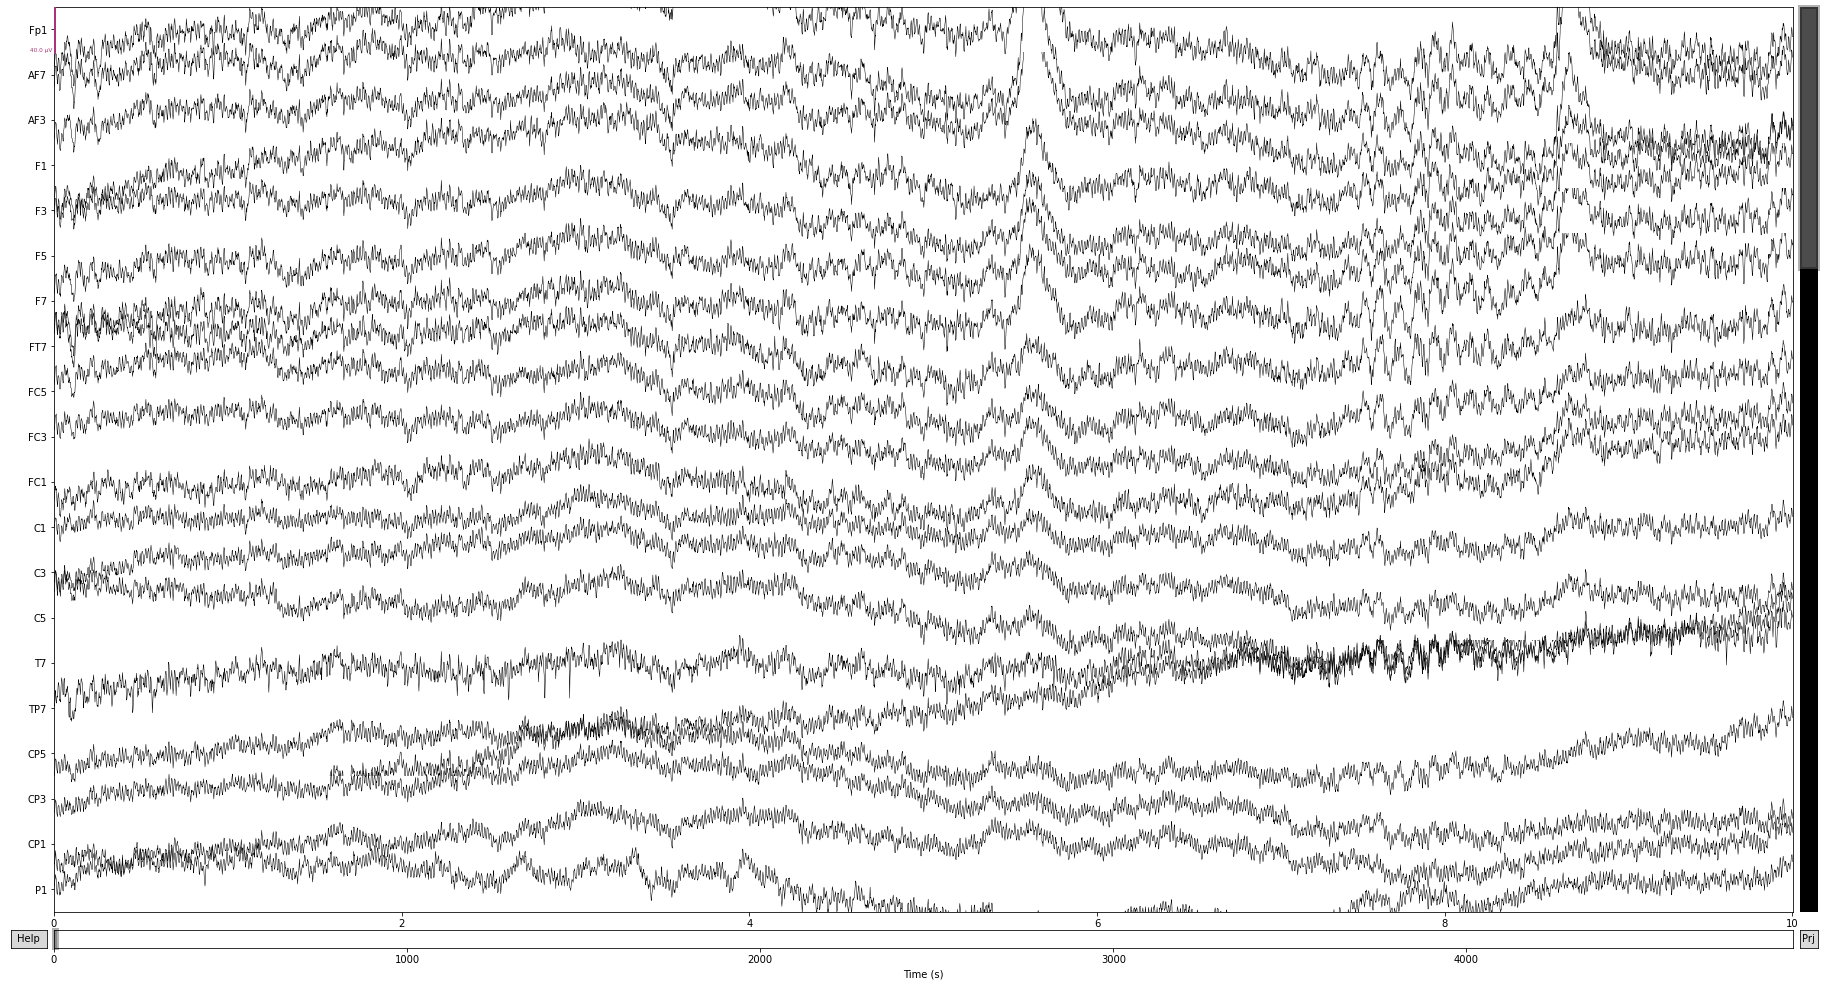

In [33]:
P05_raw = read_fif('P05')
P05_raw.plot()
del P05_raw

We will have 3 train subjects, and 6 test subjects 

In [34]:
train_subjects = ['P01', 'P04', 'P06'] 
test_subjects = ['P07', 'P09', 'P11', 'P12', 'P13', 'P14']

We integrate the steps of geting data into one function called whole_process. 

In [35]:
def whole_process(name, chs):
  #1.Get dataset
  raw = read_fif(name)

  #2. Get events of the dataset
  events = mne.find_events(raw)

  #3. Filter
  filt_raw = raw.copy().filter(l_freq=0.5, h_freq=30)

  #4. Repairing artifacts with ICA
  ica = mne.preprocessing.ICA(n_components=20, max_iter='auto', random_state=97)
  ica.fit(filt_raw)

  ica.exclude = [0, 1]

  #5. Evoked responses: epoching and averaging
  # Now we can extract epochs from the continuous data
  # get_epochs is our own method 
  epochs = mne.Epochs(filt_raw, events, preload=True)
  epochs = ica.apply(epochs, exclude=ica.exclude)

  # Drop useless non-music events like 1000, 1111 and events with condition 4
  event_id = drop_useless_events(epochs.event_id)
  # Get each events average data for channel Pz and save result to events_dic_avg
  events_dic_avg = avg_events(epochs, chs, event_id)
  # Minimize the number of points in each events from 359 to 60 and save result to result
  result = minimize_event(events_dic_avg)
  del raw, filt_raw
  return result

In [36]:
%%capture 
# hide output
train_dict = {}
test_dict = {}
# first deal with train dict
for t in train_subjects:
  # we already have P01 data skip it
  if t == 'P01':
    train_dict[t] = events_dic_avg_min
  else:
    train_dict[t] = whole_process(t, good_channel)

# then deal with test dict
for s in test_subjects:
  # we already have P01 data skip it
  test_dict[s] = whole_process(s, good_channel)


In [37]:
print(train_dict.keys())
print(test_dict.keys())

dict_keys(['P01', 'P04', 'P06'])
dict_keys(['P07', 'P09', 'P11', 'P12', 'P13', 'P14'])


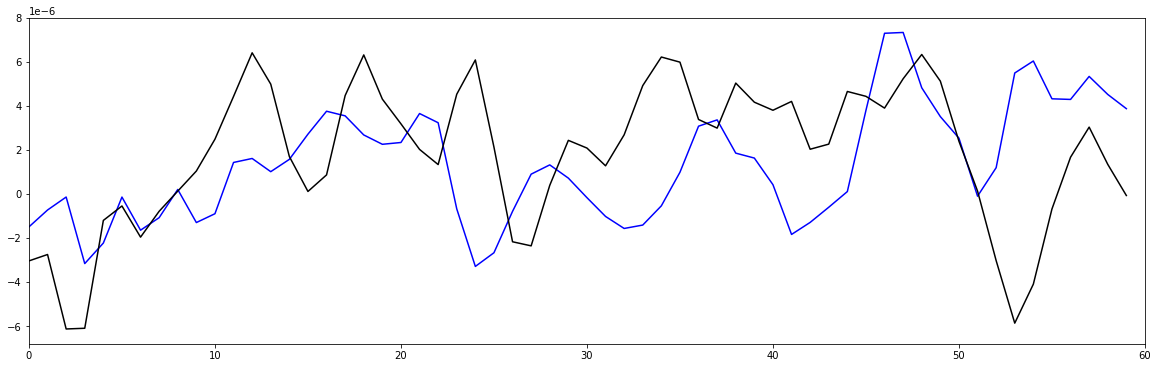

In [43]:
# pick one train subject and one test subject compare same event for them
fig, ax = plt.subplots(figsize=(20, 6))
x = np.arange(0, 60, 1)
y = train_dict['P06']['11']
z = test_dict['P09']['11']

ax.plot(y, color='blue', label='Train P04 event 11')
ax.plot(z, color='black', label='Test P07 event 11')

plt.xlim([0, 60])
plt.show()

## delelte after we done the part 2

In [39]:
import json

with open('train.json', 'w') as fp:
    json.dump(train_dict, fp)

with open('test.json', 'w') as fp:
    json.dump(test_dict, fp)